In [28]:
import os
import rampwf as rw
from sklearn.model_selection import TimeSeriesSplit
import holidays
from pathlib import Path
import numpy as np
import sklearn
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.base import TransformerMixin
import datetime

#only here
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#data

problem_title = "Bike count prediction"
_target_column_name = "log_bike_count"
# A type (class) which will be used to create wrapper objects for y_pred
Predictions = rw.prediction_types.make_regression()
# An object implementing the workflow
workflow = rw.workflows.EstimatorExternalData()

score_types = [
    rw.score_types.RMSE(name="rmse", precision=3),
]


def get_cv(X, y, random_state=0):
    cv = TimeSeriesSplit(n_splits=8)
    rng = np.random.RandomState(random_state)

    for train_idx, test_idx in cv.split(X):
        # Take a random sampling on test_idx so it's that samples are not consecutives.
        yield train_idx, rng.choice(test_idx, size=len(test_idx) // 3, replace=False)


def _read_data(path, f_name):
    data = pd.read_parquet(os.path.join(path, "data", f_name))
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array


def get_train_data(path="."):
    f_name = "train.parquet"
    return _read_data(path, f_name)


def get_test_data(path="."):
    f_name = "test.parquet"
    return _read_data(path, f_name)


X_train, y_train = get_train_data()
X_test, y_test = get_test_data()


In [4]:
# external data
def _merge_external_data(X):
    #file_path = Path(__file__).parent / "external_data.csv"  # uncomment for submission
    file_path = 'external_data.csv' #comment for submission - path to external data
    df_ext = pd.read_csv(file_path, parse_dates=["date"])
    
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        #X.sort_values("date"), df_ext[["date", "rr1","rr3","rr6","rr12","rr24","phenspe1","phenspe2","phenspe3","phenspe4", "t", "ff"]].sort_values("date"), on="date"
        X.sort_values("date"), df_ext.sort_values("date"), on="date"
    )
    # Sort back to the original order
    X["ff_2"] = X["ff"]**2
    X=X.fillna(X.mean())
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [5]:
# basic data
def _encode_dates(X):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    #X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X.loc[:, "weekday_hour"] = X["weekday"].astype(str)+X["hour"].astype(str)

    X = fr_holi(X)

    # Finally we can drop the original columns from the dataframe
    X = X.drop(columns=["date"])
    return X

In [6]:
# is holiday, to array

def fr_holi(X):
    X = X.copy()
    fr_holidays = holidays.France(years=[2018, 2019, 2020, 2021, 2022])

    X["date"] = X["date"].dt.date
    X['isholiday']=X['date'].apply(lambda x : 1 if x in fr_holidays else 0)
    return X


In [29]:
#CatBoost
 
def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    holidays_columns = ["isholiday"]
    time_columns = ["month", "year","weekday", "hour"]
    place_columns = ["site_name"]
    weather_columns = ["u", "t", "ff"]
    phenomenon_columns = ["phenspe2"]
 
    preprocessor = ColumnTransformer([
            ('time', "passthrough", time_columns),
            ('place', OneHotEncoder(categories='auto',handle_unknown='ignore'), place_columns),
            ('weather', "passthrough", weather_columns),
        ], remainder="drop")
 
    regressor = CatBoostRegressor()
 
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder, 
        preprocessor, 
        regressor)
 
    return pipe

In [ ]:
#model 3 - HistGradientBoosting

def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    time_columns = ["month", "weekday", "hour"]
    place_columns = ["site_name"]
    weather_columns = ["u", "ff", "t"] 

    preprocessor = ColumnTransformer([
            #('holidays', OneHotEncoder(), holidays_columns),
            ('time', "passthrough", time_columns),
            ('place', OneHotEncoder(categories='auto',handle_unknown='ignore'), place_columns),
            ('weather', "passthrough", weather_columns)
        ], remainder="drop")

    regressor = GradientBoostingRegressor(max_depth=9, n_estimators=50, verbose=3)

    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder, 
        preprocessor, 
        regressor)

    return pipe

In [ ]:
#Rigde

def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    date_cols = ["year", "month", "weekday", "hour"]
    categorical_cols = ["counter_name", "site_name"]#,"isholiday"]
    long_lat = ["longitude", "latitude"]

    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("holidays","passthrough", ["isholiday"]),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            #("longlat", Pipeline(
            #    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
            #), long_lat)
        ]#, remainder="passthrough"
    )

    #regressor = HistGradientBoostingClassifier()
    regressor = Ridge()

    pipe = make_pipeline(date_encoder, preprocessor, regressor)
    return pipe

In [30]:
# outcome 

pipe = get_estimator()
pipe.fit(X_train, y_train)

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.20f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.20f}"
)


/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


      Iter       Train Loss   Remaining Time 
         1           2.4262            1.68m
         2           2.1187            1.59m
         3           1.8662            1.56m
         4           1.6524            1.51m
         5           1.4815            1.50m
         6           1.3447            1.48m
         7           1.2262            1.44m
         8           1.1192            1.40m
         9           1.0317            1.36m
        10           0.9622            1.34m
        11           0.9047            1.30m
        12           0.8539            1.28m
        13           0.8066            1.24m
        14           0.7695            1.21m
        15           0.7369            1.18m
        16           0.7009            1.15m
        17           0.6764            1.11m
        18           0.6478            1.08m
        19           0.6263            1.04m
        20           0.6073            1.00m
        21           0.5907           57.79s
        2

/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


Train set, RMSE=0.61617602320817399519


/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


Test set, RMSE=0.57905513209195136337


data analysis below

In [31]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


Text(0, 0.5, 'bike count')

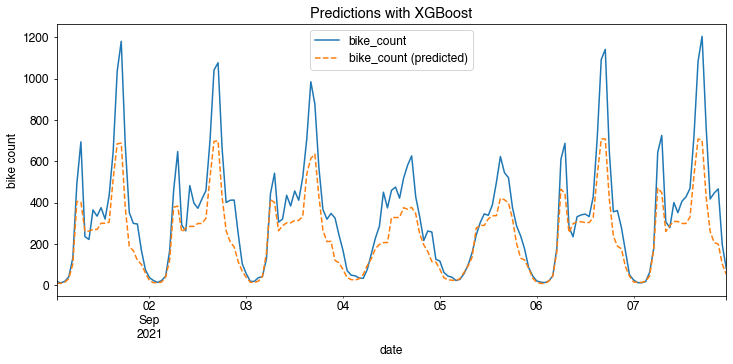

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))


df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")

font = {'family':'Helvetica',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

ax.set_title("Predictions with XGBoost")
ax.set_ylabel("bike count")

/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  X=X.fillna(X.mean())
/var/folders/hl/4ct3qq0n0fjdb0_pk794mfm40000gn/T/ipykernel_61516/3485552147.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X=X.fillna(X.mean())


<AxesSubplot:xlabel='Y true', ylabel='Y predicted'>

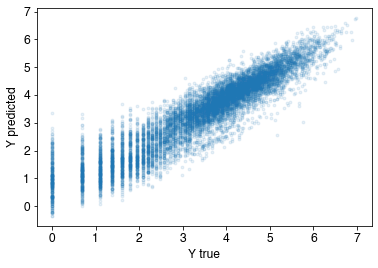

In [27]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"Y true": y_test, "Y predicted": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="Y true", y="Y predicted", s=8, alpha=0.1, ax=ax)